In [25]:
import xarray as xr
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client
import numpy as np                                                                                        
import zarr

c = Client()
c

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:34676 Dashboard: http://127.0.0.1:46027/status,Cluster Workers: 8 Cores: 48 Memory: 134.91 GB


In [26]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy.ma as ma
import numpy as np
import netCDF4 as nc4
import xarray as xr
import os
import matplotlib
from matplotlib.colors import LogNorm
import pylab as plt
import numpy as np
import pyproj

%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [27]:
#data and grid
gridname='/scratch/cnt0024/hmg2840/albert7a/NACHOS12.L75/NACHOS12.L75-I/NACHOS12.L75_domain_cfg_newbathy.nc'
dgrid=xr.open_dataset(gridname)
navlon=dgrid['nav_lon']
navlat=dgrid['nav_lat']

wname='/scratch/cnt0024/hmg2840/albert7a/NACHOS12.L75/NACHOS12.L75-MAA4001-S/1d/2010/NACHOS12.L75-MAA4001_y2010m09d07.1d_gridW.nc'
dw=xr.open_dataset(wname,chunks={'x':1000,'y':1000,'time_counter':1,'depthw':1})
w=dw['voavt']
depthw=dw['depthw']

maskname='/scratch/cnt0024/hmg2840/albert7a/NACHOS12.L75/NACHOS12.L75-I/NACHOS12.L75-MAA4001_mesh_mask.nc'
dsmask=xr.open_dataset(maskname,chunks={'x':1000,'y':1000,'time_counter':1,'nav_lev':1})
wmask=dsmask['fmask']

In [28]:
ee = pyproj.Geod(ellps='GRS80')

In [29]:
def section_from_debut_fin_points(lon_ar7w_debut,lat_ar7w_debut,lon_ar7w_fin,lat_ar7w_fin,navlon,navlat,var):
    
    ee = pyproj.Geod(ellps='GRS80') # ellipsoid used for distance calculation
    
    def distance(lat1,lon1,lat2,lon2,geoid):
        az12,az21,dist = geoid.inv(lon1,lat1,lon2,lat2)
        return dist

    def loclatlon(navlon,navlat,lon,lat):
        ind_debut=np.where((navlon>lon-0.1)&(navlon<lon+0.1)&(navlat>lat-0.1)&(navlat<lat+0.1))
        dis=np.empty(len(ind_debut[0]))
        for ii in range(0,len(ind_debut[0])):
            dis[ii]=np.abs(distance(lat,lon,navlat[ind_debut[0][ii],ind_debut[1][ii]],navlon[ind_debut[0][ii],ind_debut[1][ii]],ee))
        ind=np.argmin(dis)
        i_debut=ind_debut[0][ind]
        j_debut=ind_debut[1][ind]
    
        return i_debut,j_debut
 
    def secfromdebuttofin(i_debut,j_debut,i_fin,j_fin):
        off=1
        fromi=np.atleast_1d(i_debut)+off
        fromj=np.atleast_1d(j_debut)+off
        toi=np.atleast_1d(i_fin)+off
        toj=np.atleast_1d(j_fin)+off

        veci=fromi
        vecj=fromj

        a=(toj-fromj)/((toi-fromi).astype(np.float))
        b=toj-toi*a

        while not((veci[-1]==toi) & (vecj[-1]==toj)):
            newi=veci[-1]+np.sign(toi-fromi)
            newj=vecj[-1]+np.sign(toj-fromj)
            y=a*newi+b
            x=(newj-b)/(a.astype(np.float))

            if ((np.abs(x-veci[-1]))>=(np.abs(y-vecj[-1]))):
                veci=np.append(veci,newi)
                vecj=np.append(vecj,vecj[-1])
            else:
                veci=np.append(veci,veci[-1])
                vecj=np.append(vecj,newj)

        veci=veci.astype(np.int)-off
        vecj=vecj.astype(np.int)-off

        dis=np.empty(len(veci))
        for ii in range(0,len(veci)):
            dis[ii]=np.abs(distance(navlat[veci[0],vecj[0]],navlon[veci[0],vecj[0]],navlat[veci[ii],vecj[ii]],navlon[veci[ii],vecj[ii]],ee))
    
        return veci,vecj,dis
            
    i_debut,j_debut=loclatlon(navlon,navlat,lon_ar7w_debut,lat_ar7w_debut)
    i_fin,j_fin=loclatlon(navlon,navlat,lon_ar7w_fin,lat_ar7w_fin)

    veci,vecj,dis=secfromdebuttofin(i_debut,j_debut,i_fin,j_fin)

    if np.ndim(var) == 4:
        [nt,nk,nj,ni]=var.shape
        var_sec=np.empty([nt,nk,len(veci)])
        for ii in range(0,len(veci)):
            var_sec[:,:,ii]=var[:,:,veci[ii],vecj[ii]]
    if np.ndim(var) == 3:
        [nt,nj,ni]=var.shape
        var_sec=np.empty([nt,len(veci)])
        for ii in range(0,len(veci)):
            var_sec[:,ii]=var[:,veci[ii],vecj[ii]]
    
    return veci,vecj,dis,var_sec

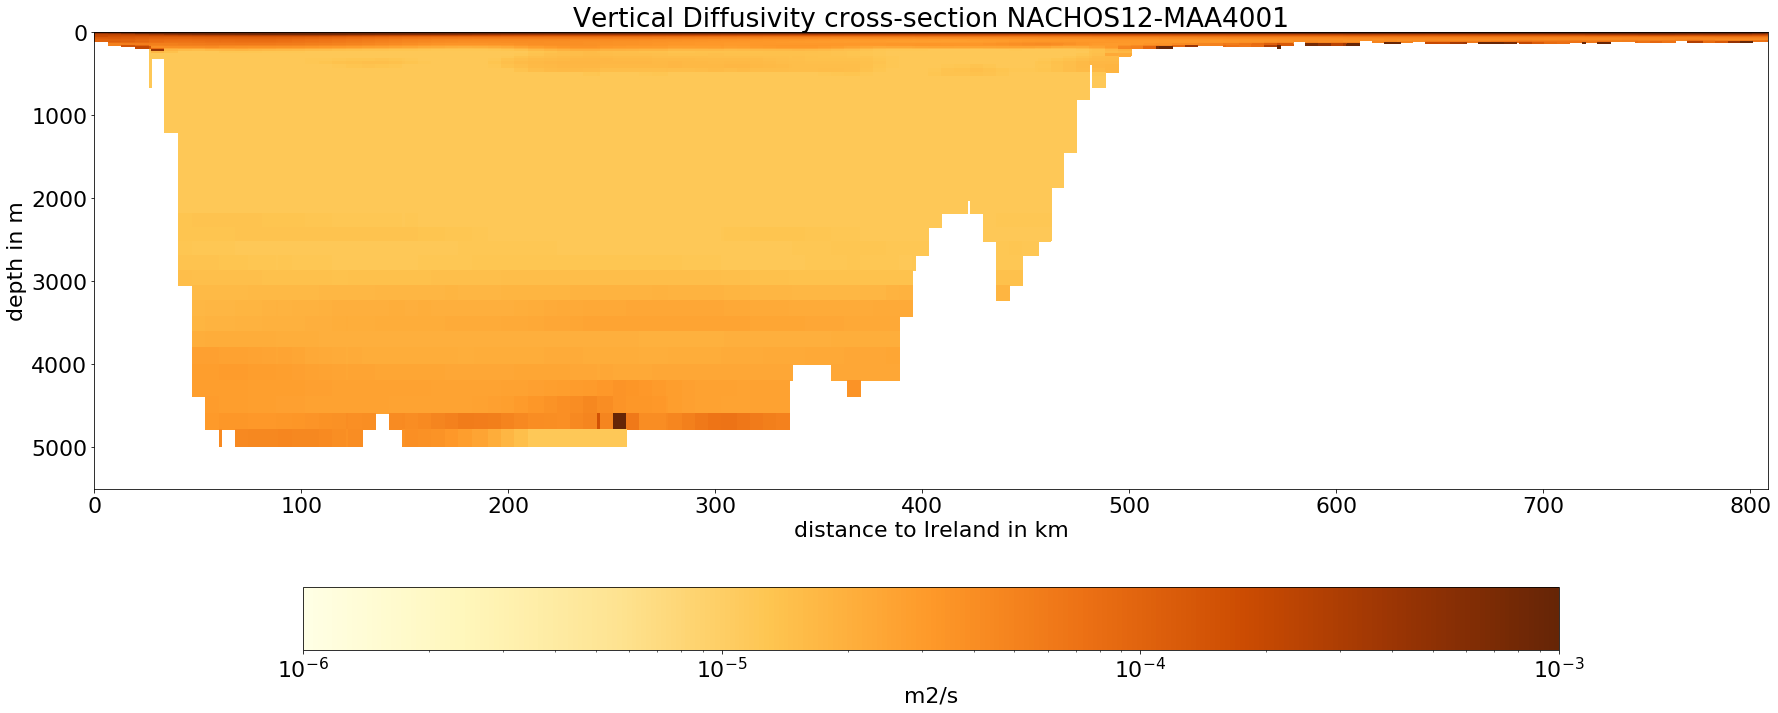

In [36]:
#irespain section beginning and end point

lon_irespain_debut=np.array(-7.7).astype(np.float)
lon_irespain_fin=np.array(-9.4).astype(np.float)

lat_irespain_debut=np.array(43.8).astype(np.float)
lat_irespain_fin=np.array(51).astype(np.float)

ma_w = np.ma.masked_where(1-wmask,w)

veci,vecj,dis,wirespain=section_from_debut_fin_points(lon_irespain_debut,lat_irespain_debut,lon_irespain_fin,lat_irespain_fin,navlon,navlat,ma_w)



matplotlib.rcParams.update({'font.size': 22})

plt.figure(figsize=(30,12))
ax=plt.subplot(1,1,1)
cmap2 = plt.cm.seismic
cmap2.set_under('b')
cmap2.set_over('r')
pcolor=plt.pcolor(1e-3*dis,depthw,wirespain[0,:,:],norm=LogNorm(vmin=1e-6,vmax=1e-3),cmap='YlOrBr')
plt.gca().invert_yaxis()
cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75,label='m2/s')
ax.set_ylim(5500,0)
#ax.set_xlim(100,900)
plt.xlabel('distance to Ireland in km')
plt.ylabel('depth in m')
plt.title('Vertical Diffusivity cross-section NACHOS12-MAA4001');
plt.savefig("vertical_diffusivity_ireland-spain_NACHOS12-MAA4001.png")


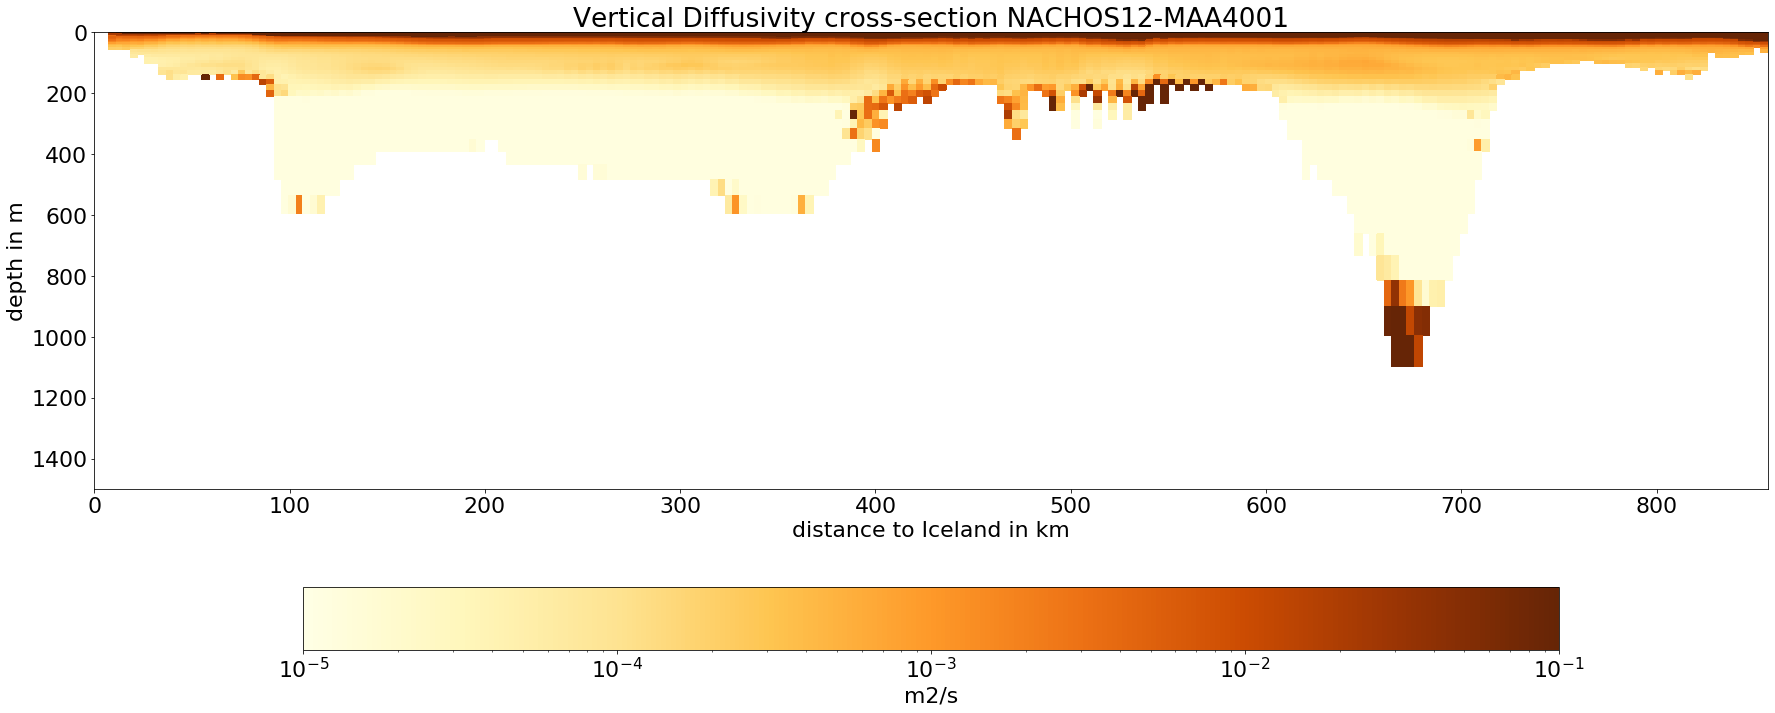

In [37]:
#icescotland section beginning and end point

lon_icescotland_debut=np.array(-14.205).astype(np.float)
lon_icescotland_fin=np.array(-3.319).astype(np.float)

lat_icescotland_debut=np.array(64.72).astype(np.float)
lat_icescotland_fin=np.array(58.988).astype(np.float)

ma_w = np.ma.masked_where(1-wmask,w)

veci,vecj,dis,wicescotland=section_from_debut_fin_points(lon_icescotland_debut,lat_icescotland_debut,lon_icescotland_fin,lat_icescotland_fin,navlon,navlat,ma_w)


matplotlib.rcParams.update({'font.size': 22})

plt.figure(figsize=(30,12))
ax=plt.subplot(1,1,1)
cmap2 = plt.cm.seismic
cmap2.set_under('b')
cmap2.set_over('r')
pcolor=plt.pcolor(1e-3*dis,depthw,wicescotland[0,:,:],norm=LogNorm(vmin=1e-5,vmax=1e-1),cmap='YlOrBr')
plt.gca().invert_yaxis()
cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75,label='m2/s')
ax.set_ylim(1500,0)
#ax.set_xlim(100,900)
plt.xlabel('distance to Iceland in km')
plt.ylabel('depth in m')
plt.title('Vertical Diffusivity cross-section NACHOS12-MAA4001');


plt.savefig("vertical_diffusivity_iceland-ireland_NACHOS12-MAA4001.png")